In [1]:
# ============================================
# 1) IMPORT LIBRARY
# ============================================
import pandas as pd
import random
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset


import torch
from torch import nn

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [2]:
# ==================================================
# 2) BACA DATA
# ==================================================
df = pd.read_csv("/content/cleaned_for_training_final (3).csv")

print("\n=== Step 2: Dataset Loaded ===")
print("Jumlah total data :", len(df))
print("\nDistribusi Label (SEBELUM SPLIT):")
print(df['label'].value_counts())
print("\nPersentase Label (SEBELUM SPLIT):")
print((df['label'].value_counts(normalize=True) * 100).round(4))



=== Step 2: Dataset Loaded ===
Jumlah total data : 7178

Distribusi Label (SEBELUM SPLIT):
label
0    4374
1    2804
Name: count, dtype: int64

Persentase Label (SEBELUM SPLIT):
label
0    60.9362
1    39.0638
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# ==================================================
# 3) SPLIT DATA (70:15:15) DENGAN STRATIFY
# ==================================================
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label"]
)

train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1765,         # 0.1765 x 0.85 ≈ 0.15
    random_state=42,
    stratify=train_df["label"]
)

print("\n=== Step 3: Split Completed ===")
print("Train :", len(train_df), "|", round(len(train_df)/len(df)*100,2), "%")
print("Valid :", len(valid_df), "|", round(len(valid_df)/len(df)*100,2), "%")
print("Test  :", len(test_df),  "|", round(len(test_df)/len(df)*100,2), "%")

print("\nDistribusi TRAIN:")
print(train_df['label'].value_counts())
print((train_df['label'].value_counts(normalize=True) * 100).round(2))

print("\nDistribusi VALID:")
print(valid_df['label'].value_counts())
print((valid_df['label'].value_counts(normalize=True) * 100).round(2))

print("\nDistribusi TEST:")
print(test_df['label'].value_counts())
print((test_df['label'].value_counts(normalize=True) * 100).round(2))



=== Step 3: Split Completed ===
Train : 5024 | 69.99 %
Valid : 1077 | 15.0 %
Test  : 1077 | 15.0 %

Distribusi TRAIN:
label
0    3062
1    1962
Name: count, dtype: int64
label
0    60.95
1    39.05
Name: proportion, dtype: float64

Distribusi VALID:
label
0    656
1    421
Name: count, dtype: int64
label
0    60.91
1    39.09
Name: proportion, dtype: float64

Distribusi TEST:
label
0    656
1    421
Name: count, dtype: int64
label
0    60.91
1    39.09
Name: proportion, dtype: float64


In [ ]:
from collections import Counter
import pandas as pd

def apply_PRUS(df, label="label", target_ratio=1.5, seed=42):
    """
    Partial Random Undersampling (PRUS)

    target_ratio = mayoritas : minoritas (final)

    """
    vc = df[label].value_counts()
    majority = vc.idxmax()
    minority = vc.idxmin()

    df_maj = df[df[label] == majority]
    df_min = df[df[label] == minority]

    # target mayoritas setelah undersampling
    target_maj_size = int(len(df_min) * target_ratio)

    # Jika target mayoritas >= mayoritas asli, artinya tidak perlu undersampling
    if target_maj_size >= len(df_maj):
        return df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # sample mayoritas (tanpa replacement)
    df_maj_down = df_maj.sample(n=target_maj_size, replace=False, random_state=seed)

    # gabungkan + shuffle
    df_prus = pd.concat([df_min, df_maj_down]).sample(frac=1, random_state=seed)
    return df_prus.reset_index(drop=True)


In [ ]:
# ==================================================
# 5) PRUS DIAPLIKASIKAN KE TRAIN
#    target_ratio = 1.5 (hampir seimbang 1:1)
# ==================================================
train_prus = apply_PRUS(train_df, label="label", target_ratio=1.5, seed=42)

print("\n=== Step 5: PRUS Applied ===")
print("SEBELUM PRUS:")
print(train_df['label'].value_counts(), "\n")
print("SESUDAH PRUS:")
print(train_prus['label'].value_counts(), "\n")

print("Persentase SEBELUM PRUS:")
print((train_df['label'].value_counts(normalize=True) * 100).round(2), "\n")

print("Persentase SESUDAH PRUS:")
print((train_prus['label'].value_counts(normalize=True) * 100).round(2))


=== Step 5: PRUS Applied ===
SEBELUM PRUS:
label
0    3062
1    1962
Name: count, dtype: int64 

SESUDAH PRUS:
label
0    2943
1    1962
Name: count, dtype: int64 

Persentase SEBELUM PRUS:
label
0    60.95
1    39.05
Name: proportion, dtype: float64 

Persentase SESUDAH PRUS:
label
0    60.0
1    40.0
Name: proportion, dtype: float64


In [7]:
# ============================================
# 6) TOKENIZER
# ============================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
# ==================================================
# 6) CLASS WEIGHT BERDASARKAN TRAIN_PROS
# ==================================================
labels_pros = train_prus["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_pros),
    y=labels_pros
)

# override manual
class_weights[0] = 1.0
class_weights[1] = 1.2

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(class_weights_tensor)

tensor([1.0000, 1.2000], device='cuda:0')


In [9]:
# ============================================
# 6) TOKENIZER
# ============================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
def tokenize_function(batch):
    return tokenizer(
        batch["clean_text"],          # pastikan nama kolom ini ada di CSV
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [ ]:
from datasets import Dataset

# ==================================================
# 8) CONVERT PANDAS → HF DATASET
# ==================================================
# TRAIN (PRUS)
train_ds = Dataset.from_pandas(train_prus.reset_index(drop=True))
train_ds = train_ds.map(tokenize_function, batched=True)
train_ds = train_ds.remove_columns(
    [c for c in train_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# VALID
valid_ds = Dataset.from_pandas(valid_df.reset_index(drop=True))
valid_ds = valid_ds.map(tokenize_function, batched=True)
valid_ds = valid_ds.remove_columns(
    [c for c in valid_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
valid_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# TEST
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))
test_ds = test_ds.map(tokenize_function, batched=True)
test_ds = test_ds.remove_columns(
    [c for c in test_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1_macro, _ = precision_recall_fscore_support(
        labels, preds,
        average="macro",
        zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_macro": f1_macro,
    }

In [13]:
# ============================================
# 8) WEIGHT TENSOR & WEIGHTED TRAINER
# ============================================
from transformers import Trainer
import torch.nn as nn
import torch

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")

        # Hapus labels sebelum masuk ke model
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

        logits = outputs.get("logits")

        # CrossEntropyLoss dengan class weight
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)

        # FIX return
        if return_outputs:
            return loss, outputs
        else:
            return loss


In [15]:
best_params = {'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 3, 'best_epoch': 2}
print("Defined best_params:", best_params)

Defined best_params: {'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 3, 'best_epoch': 2}


In [16]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback,
)

# ambil hyperparameter terbaik dari random search
best_lr     = best_params["learning_rate"]
best_bs     = best_params["batch_size"]

print("Best params:", best_params)

# model baru untuk training final
model_final = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)



args_final = TrainingArguments(
    output_dir="./indobertweet_prus_classweight_best",
    learning_rate=best_lr,
    per_device_train_batch_size=best_bs,
    per_device_eval_batch_size=best_bs,
    num_train_epochs=3,          # train sampai epoch optimal
    eval_strategy="epoch",          # ✅ diperbaiki
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,                    # regularisasi biar ga makin overfit
    report_to="none",
    seed=42,
)

trainer_final = WeightedTrainer(
    model=model_final,
    args=args_final,
    train_dataset=train_ds,               # pastikan ini sudah PRUS
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,          # untuk class weight
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2    # stop cepat kalau mulai overfit
        )
    ]
)

trainer_final.train()

# simpan model & tokenizer buat dipakai lagi / lampiran skripsi
save_dir = "./indobertweet_prus_classweight_best"
trainer_final.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model final disimpan di:", save_dir)


Best params: {'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 3, 'best_epoch': 2}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.505800,0.400455,0.824513,0.816501,0.813400,0.814853
2,0.321400,0.590627,0.824513,0.819512,0.807869,0.812557
3,0.182800,0.724810,0.830084,0.820863,0.825631,0.822963


Model final disimpan di: ./indobertweet_prus_classweight_best


In [17]:
import pandas as pd

# evaluasi
eval_valid = trainer_final.evaluate(eval_dataset=valid_ds)
eval_test  = trainer_final.evaluate(eval_dataset=test_ds)

# pilih metrik yang mau ditampilkan
keep_keys = [
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]

def filter_metrics(dct, name):
    data = {"Dataset": name}
    for k in keep_keys:
        data[k] = dct.get(k, None)
    return data

rows = [
    filter_metrics(eval_valid, "Valid"),
    filter_metrics(eval_test,  "Test")
]

df_eval = pd.DataFrame(rows)

# urutkan kolom + rename biar lebih enak dibaca
df_eval = df_eval[[
    "Dataset",
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]].rename(columns={
    "eval_loss": "Loss",
    "eval_accuracy": "Accuracy",
    "eval_precision": "Precision",
    "eval_recall": "Recall",
    "eval_f1_macro": "F1 Macro",
    "epoch": "Epoch"
})

# bulatkan 4 desimal untuk metrik numerik
for col in ["Loss", "Accuracy", "Precision", "Recall", "F1 Macro"]:
    df_eval[col] = df_eval[col].astype(float).round(4)

df_eval = df_eval.set_index("Dataset")
df_eval


,Loss,Accuracy,Precision,Recall,F1 Macro,Epoch
Dataset,,,,,,
Valid,0.7248,0.8301,0.8209,0.8256,0.823,3.0
Test,0.6600,0.8440,0.8351,0.8422,0.838,3.0



📊 Classification Report (TEST):
              precision    recall  f1-score   support

non-sarkasme     0.8885    0.8506    0.8692       656
    sarkasme     0.7817    0.8337    0.8069       421

    accuracy                         0.8440      1077
   macro avg     0.8351    0.8422    0.8380      1077
weighted avg     0.8468    0.8440    0.8448      1077



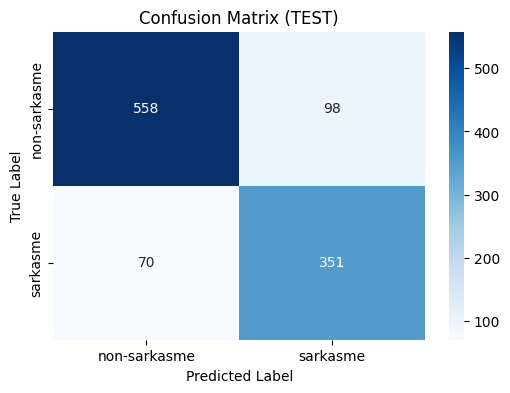

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

pred_test = trainer_final.predict(test_ds)
y_pred = np.argmax(pred_test.predictions, axis=1)
y_true = pred_test.label_ids

# Print classification report
print("\n📊 Classification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=["non-sarkasme", "sarkasme"], digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-sarkasme", "sarkasme"],
            yticklabels=["non-sarkasme", "sarkasme"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.show()

In [20]:
import pandas as pd

log_hist = pd.DataFrame(trainer_final.state.log_history)


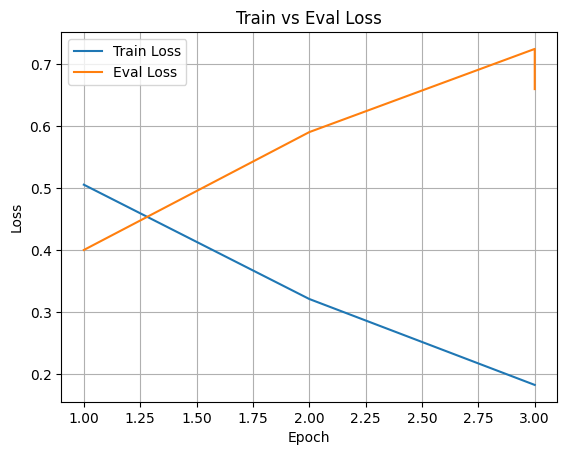

In [21]:
import matplotlib.pyplot as plt

# Filter for training logs (where 'loss' is present)
train_logs = log_hist[log_hist["loss"].notna()]
# Filter for evaluation logs (where 'eval_loss' is present)
eval_logs = log_hist[log_hist["eval_loss"].notna()]

plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid(True)
plt.show()